## Phase A: Baseline Modeling Overview

Phase A focuses on building clean, reliable baseline models for both prediction tasks in the Sleep Health & Lifestyle dataset. The goal is to prepare high-quality inputs, apply consistent preprocessing, and establish interpretable first models that will serve as reference points for all later experiments.

# 1. Data Cleaning & Preparation

Loaded the dataset and inspected structure, missing values, and distributions.

Parsed Blood Pressure into systolic and diastolic numeric fields.

Removed Person ID (non-informative identifier).

Identified numeric vs categorical features and handled missing values appropriately.

# 2. Preprocessing Pipelines

Built ColumnTransformers for classification and regression:

Numeric features → median imputation + standard scaling

Categorical features → most frequent imputation + one-hot encoding
These pipelines ensure consistent, reproducible preprocessing for all models.

# 3. Target Definition & Train/Test Split

Created two modeling datasets:

Classification: Sleep Disorder

Regression: Quality of Sleep
Performed an 80/20 split, using stratification for classification when possible.

# 4. Baseline Models

Implemented and evaluated:

Logistic Regression (classification)

Linear Regression (regression)

Collected key metrics:

Classification: accuracy, precision, recall, F1-score, confusion matrix

Regression: R², RMSE, MAE

# 5. Interpretability

Extracted top influential coefficients from Logistic Regression.

Produced a residuals vs. predicted plot for Linear Regression.

In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Make plots a bit nicer
plt.style.use("default")
plt.rcParams["figure.figsize"] = (8, 5)

# Scikit-learn tools
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    r2_score,
    mean_squared_error,
    mean_absolute_error,
)

# For saving models/metrics later
import joblib
import json


In [2]:
try:
    import kagglehub
    HAS_KAGGLEHUB = True
except ImportError:
    HAS_KAGGLEHUB = False

CSV_PATH = None

if HAS_KAGGLEHUB:
    path = kagglehub.dataset_download("uom190346a/sleep-health-and-lifestyle-dataset")
    print("Dataset directory:", path)
    print("Files found:", os.listdir(path))

    # Automatically detect a CSV file
    csv_candidates = [f for f in os.listdir(path) if f.lower().endswith(".csv")]
    if csv_candidates:
        CSV_PATH = os.path.join(path, csv_candidates[0])
        print("Using CSV:", CSV_PATH)
    else:
        print("No CSV file found in the KaggleHub directory.")
else:
    print("kagglehub not available. Please set CSV_PATH manually.")


Dataset directory: C:\Users\lucas\.cache\kagglehub\datasets\uom190346a\sleep-health-and-lifestyle-dataset\versions\2
Files found: ['Sleep_health_and_lifestyle_dataset.csv']
Using CSV: C:\Users\lucas\.cache\kagglehub\datasets\uom190346a\sleep-health-and-lifestyle-dataset\versions\2\Sleep_health_and_lifestyle_dataset.csv


In [3]:
assert CSV_PATH is not None, "CSV_PATH is not set. Make sure kagglehub downloaded the dataset correctly."

# Load the CSV
df = pd.read_csv(CSV_PATH)

print("Shape (rows, columns):", df.shape)
print("\nColumns:\n", df.columns.tolist())

print("\nFirst 5 rows:")
display(df.head())

print("\nDataFrame info():")
df.info()

print("\nDescriptive statistics (including categoricals):")
display(df.describe(include="all").T)

# Quick look at key targets
print("\nSleep Disorder value counts:")
print(df["Sleep Disorder"].value_counts(dropna=False))

print("\nQuality of Sleep summary:")
print(df["Quality of Sleep"].describe())


Shape (rows, columns): (374, 13)

Columns:
 ['Person ID', 'Gender', 'Age', 'Occupation', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'BMI Category', 'Blood Pressure', 'Heart Rate', 'Daily Steps', 'Sleep Disorder']

First 5 rows:


,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea



DataFrame info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    object 
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    object 
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    object 
 9   Blood Pressure           374 non-null    object 
 10  Heart Rate               374 non-null    int64  
 11  Daily Steps              374 non-null    int64  
 12  Sleep Disorder           155 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 38.1+ KB

De

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Person ID,374.0,NaN,NaN,NaN,187.5,108.108742,1.0,94.25,187.5,280.75,374.0
Gender,374,2,Male,189,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,374.0,NaN,NaN,NaN,42.184492,8.673133,27.0,35.25,43.0,50.0,59.0
Occupation,374,11,Nurse,73,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sleep Duration,374.0,NaN,NaN,NaN,7.132086,0.795657,5.8,6.4,7.2,7.8,8.5
Quality of Sleep,374.0,NaN,NaN,NaN,7.312834,1.196956,4.0,6.0,7.0,8.0,9.0
Physical Activity Level,374.0,NaN,NaN,NaN,59.171123,20.830804,30.0,45.0,60.0,75.0,90.0
Stress Level,374.0,NaN,NaN,NaN,5.385027,1.774526,3.0,4.0,5.0,7.0,8.0
BMI Category,374,4,Normal,195,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Blood Pressure,374,25,130/85,99,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Sleep Disorder value counts:
Sleep Disorder
NaN            219
Sleep Apnea     78
Insomnia        77
Name: count, dtype: int64

Quality of Sleep summary:
count    374.000000
mean       7.312834
std        1.196956
min        4.000000
25%        6.000000
50%        7.000000
75%        8.000000
max        9.000000
Name: Quality of Sleep, dtype: float64


Numeric columns: ['Person ID', 'Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'Heart Rate', 'Daily Steps']


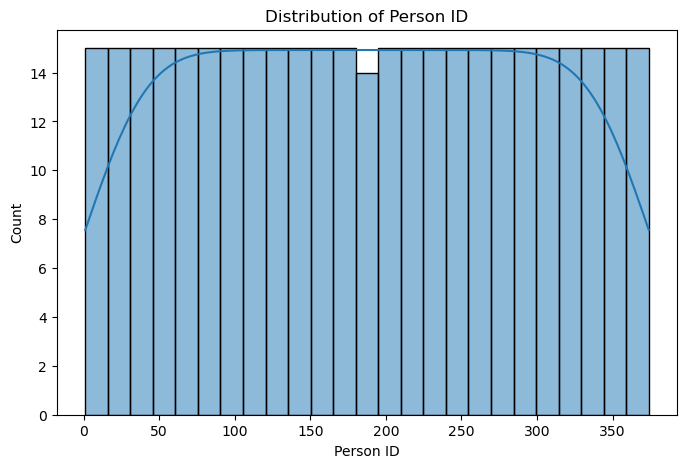

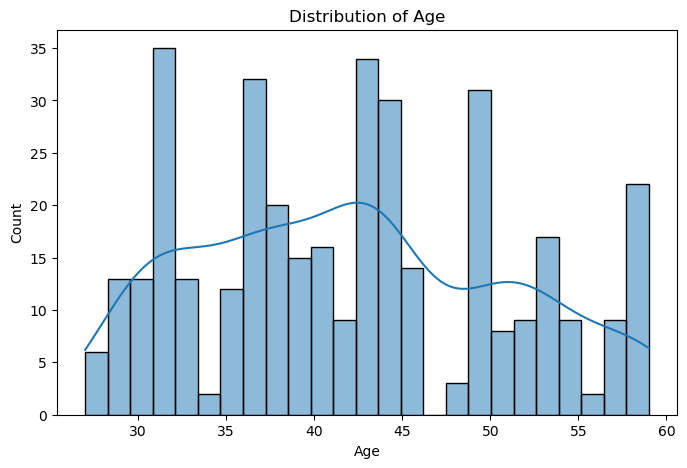

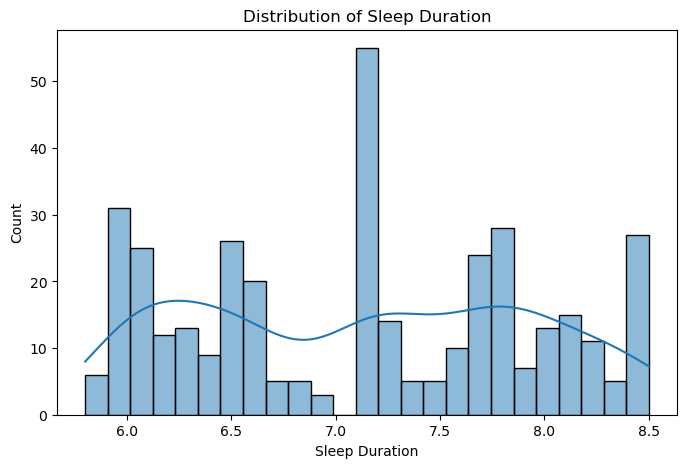

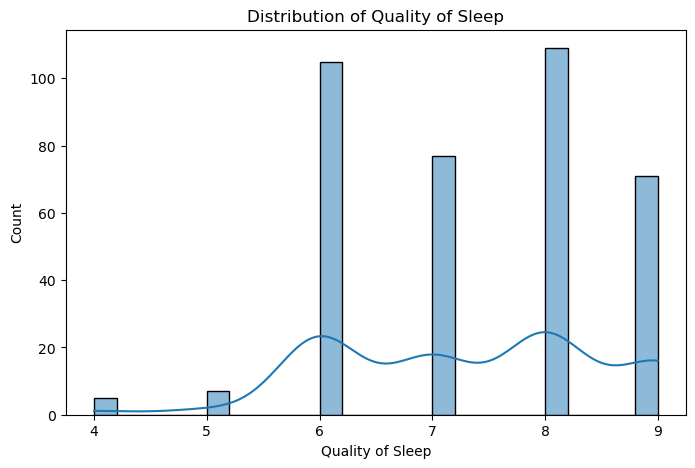

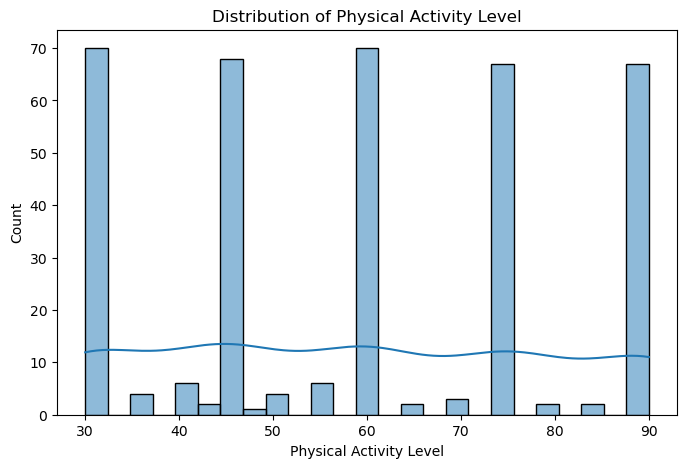

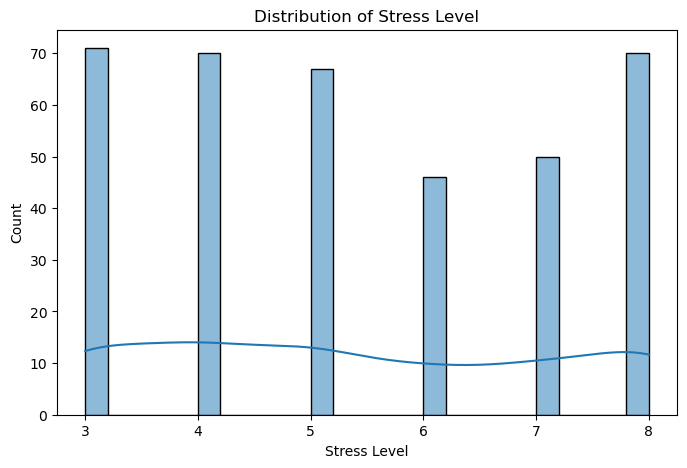

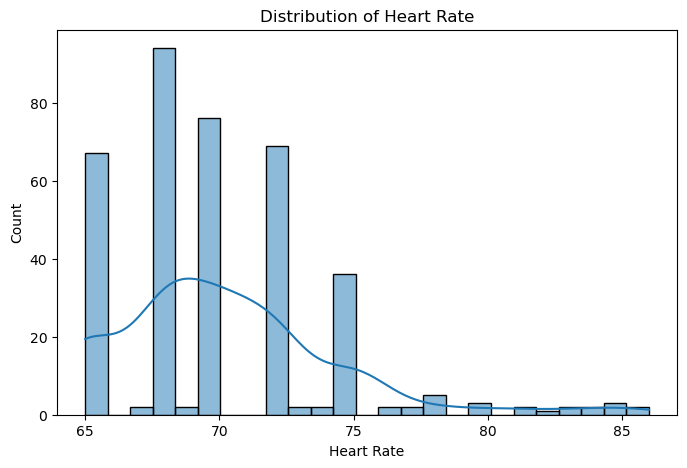

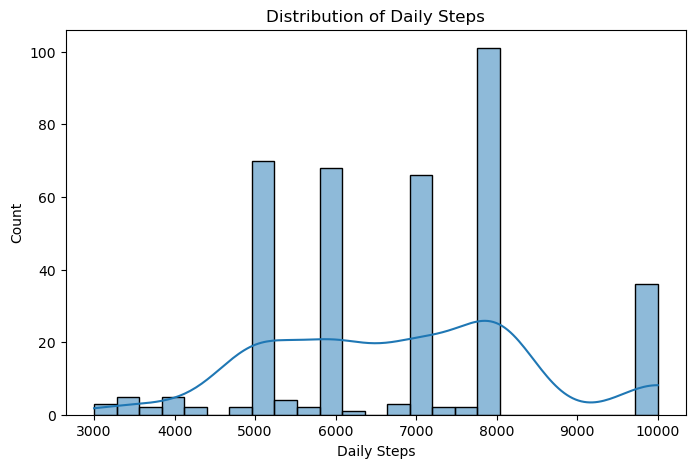

Categorical columns: ['Gender', 'Occupation', 'BMI Category', 'Blood Pressure', 'Sleep Disorder']


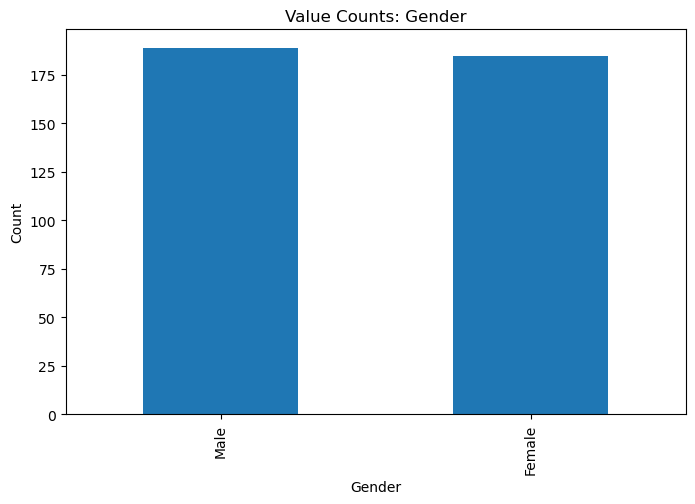

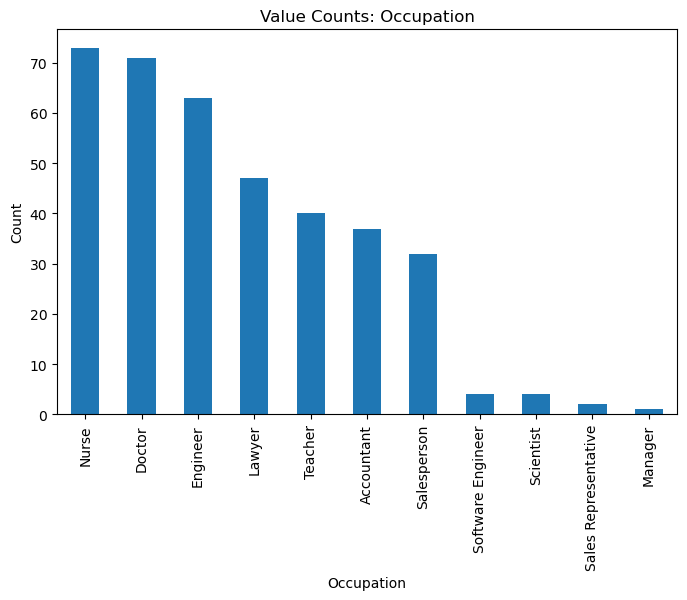

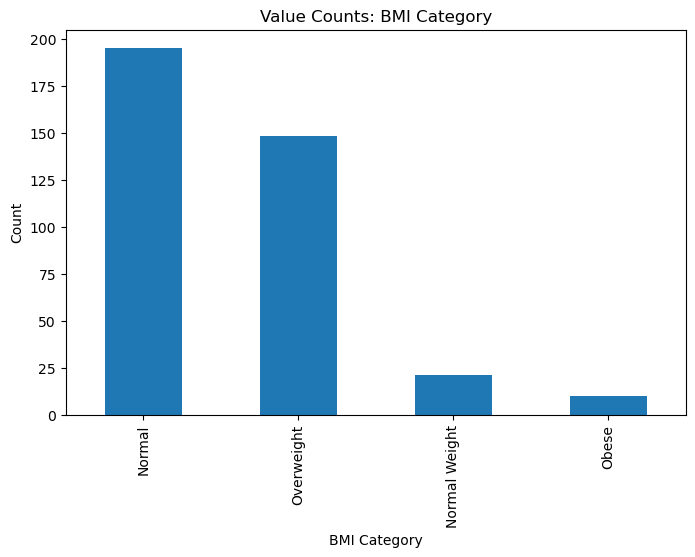

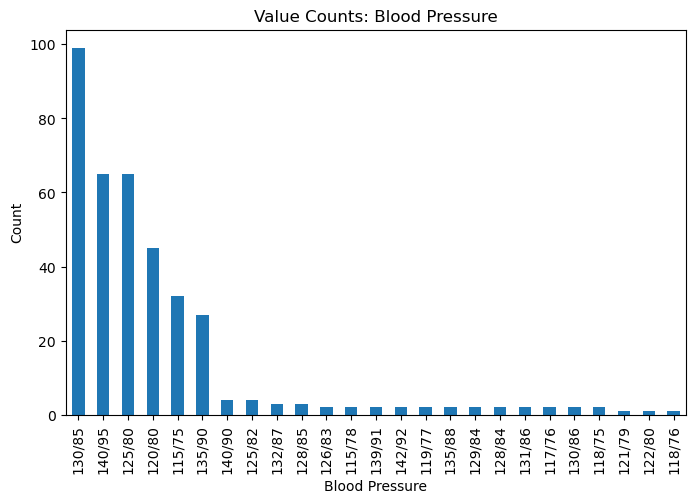

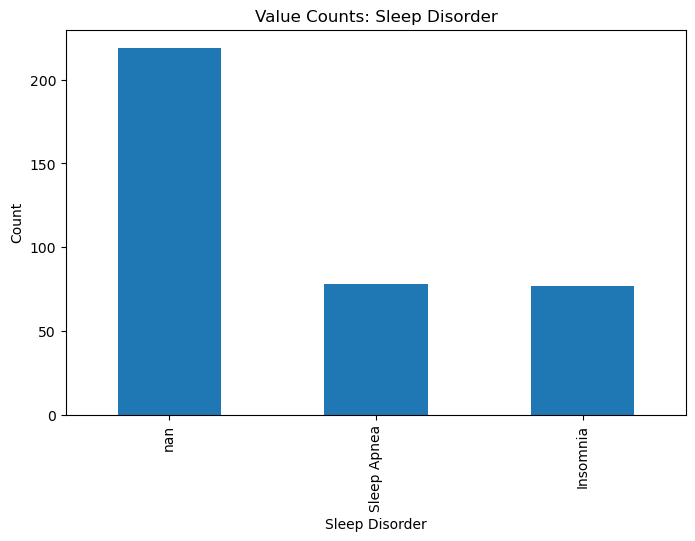

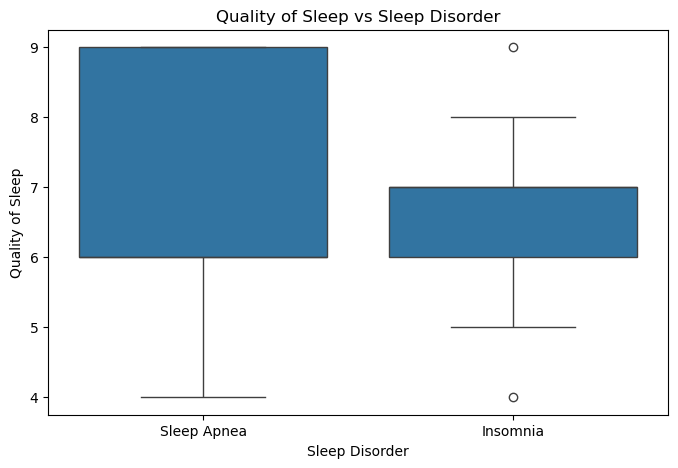

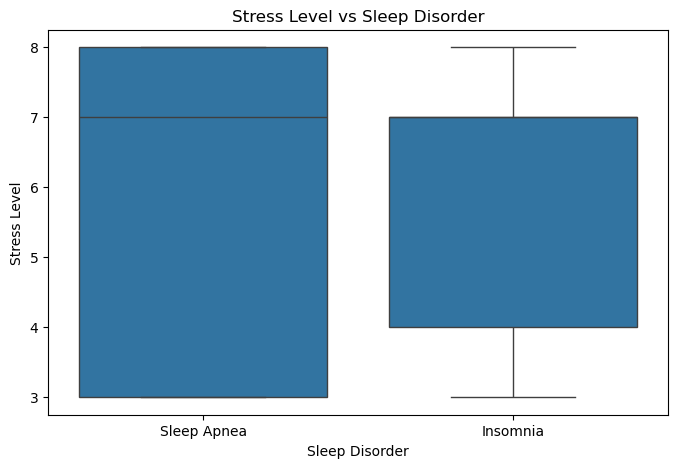

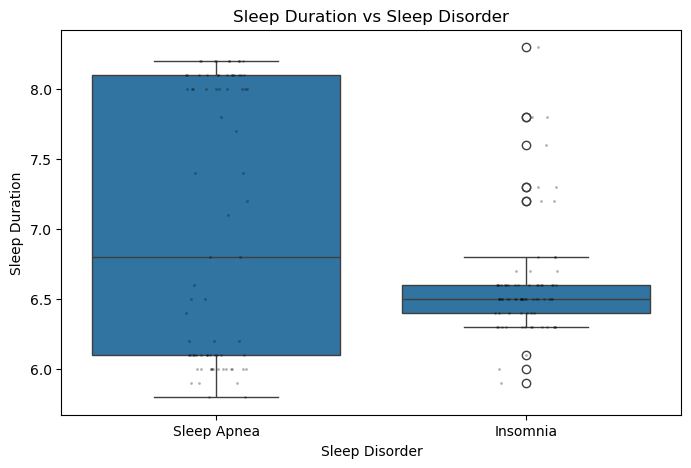

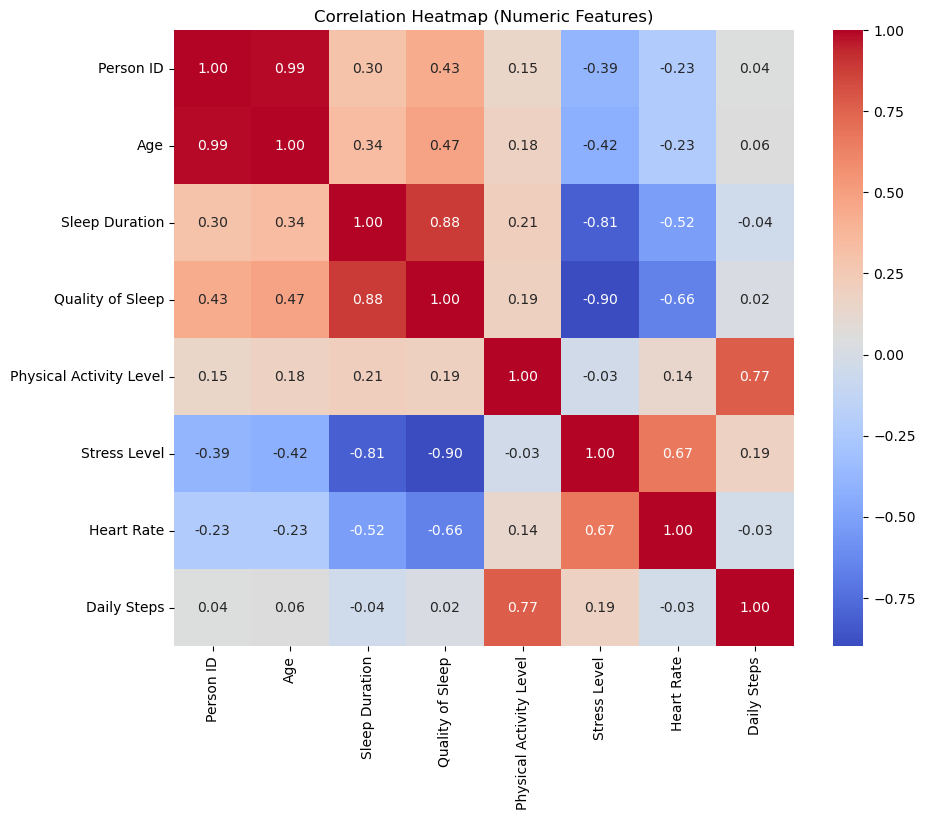

In [ ]:
import seaborn as sns

# ----------------------------
# Numeric histograms
# ----------------------------
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

print("Numeric columns:", numeric_cols)

for col in numeric_cols:
    plt.figure()
    sns.histplot(df[col], kde=True, bins=25)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()


# ----------------------------
# Categorical bar plots
# ----------------------------
categorical_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

print("Categorical columns:", categorical_cols)

for col in categorical_cols:
    plt.figure()
    df[col].value_counts(dropna=False).plot(kind="bar")
    plt.title(f"Value Counts: {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()


# ----------------------------
# Relationship plots
# ----------------------------

# Quality of Sleep vs Sleep Disorder
plt.figure()
sns.boxplot(data=df, x="Sleep Disorder", y="Quality of Sleep")
plt.title("Quality of Sleep vs Sleep Disorder")
plt.show()

# Stress Level vs Sleep Disorder
plt.figure()
sns.boxplot(data=df, x="Sleep Disorder", y="Stress Level")
plt.title("Stress Level vs Sleep Disorder")
plt.show()

# Sleep Duration vs Sleep Disorder
plt.figure()
sns.boxplot(data=df, x="Sleep Disorder", y="Sleep Duration")
sns.stripplot(data=df, x="Sleep Disorder", y="Sleep Duration",
              color="black", size=2, jitter=True, alpha=0.3)
plt.title("Sleep Duration vs Sleep Disorder")
plt.show()


# ----------------------------
# Correlation heatmap for numeric features
# ----------------------------
plt.figure(figsize=(10, 8))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()


In [5]:
# Start from the original df
df_clean = df.copy()

# 1) Parse Blood Pressure "120/80" -> BP_Systolic, BP_Diastolic
bp_split = df_clean["Blood Pressure"].str.split("/", expand=True)

df_clean["BP_Systolic"] = pd.to_numeric(bp_split[0], errors="coerce")
df_clean["BP_Diastolic"] = pd.to_numeric(bp_split[1], errors="coerce")

# Drop original string column (we'll use the numeric versions)
df_clean = df_clean.drop(columns=["Blood Pressure"])

# 2) Drop Person ID (pure identifier, not a real feature)
df_clean = df_clean.drop(columns=["Person ID"])

# 3) Quick sanity checks
print("df_clean shape:", df_clean.shape)
print("Columns:", df_clean.columns.tolist())
print("\nMissing values per column:")
print(df_clean.isnull().sum())

# 4) Define targets and feature matrices for both tasks

# Classification: Sleep Disorder (we'll drop rows with missing label later)
y_cls = df_clean["Sleep Disorder"]
X_cls = df_clean.drop(columns=["Sleep Disorder"])

# Regression: Quality of Sleep
y_reg = df_clean["Quality of Sleep"]
X_reg = df_clean.drop(columns=["Quality of Sleep"])

# 5) Identify numeric and categorical columns from the classification features
num_cols = X_cls.select_dtypes(include=np.number).columns.tolist()
cat_cols = [c for c in X_cls.columns if c not in num_cols]

print("\nNumeric columns:", num_cols)
print("Categorical columns:", cat_cols)


df_clean shape: (374, 13)
Columns: ['Gender', 'Age', 'Occupation', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'BMI Category', 'Heart Rate', 'Daily Steps', 'Sleep Disorder', 'BP_Systolic', 'BP_Diastolic']

Missing values per column:
Gender                       0
Age                          0
Occupation                   0
Sleep Duration               0
Quality of Sleep             0
Physical Activity Level      0
Stress Level                 0
BMI Category                 0
Heart Rate                   0
Daily Steps                  0
Sleep Disorder             219
BP_Systolic                  0
BP_Diastolic                 0
dtype: int64

Numeric columns: ['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'Heart Rate', 'Daily Steps', 'BP_Systolic', 'BP_Diastolic']
Categorical columns: ['Gender', 'Occupation', 'BMI Category']


In [6]:
# Numeric pipeline
num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical pipeline
cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

# ColumnTransformer for classification
preprocess_cls = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
    ]
)

# ColumnTransformer for regression (auto-select numeric/categorical)
preprocess_reg = ColumnTransformer(
    transformers=[
        ("num", num_pipe, selector(dtype_include=np.number)),
        ("cat", cat_pipe, selector(dtype_exclude=np.number)),
    ]
)

print("Preprocessing pipelines created successfully.")


Preprocessing pipelines created successfully.


In [7]:
# Classification dataset: drop rows with no label
mask_cls = df_clean["Sleep Disorder"].notna()
X_cls = X_cls[mask_cls]
y_cls = y_cls[mask_cls]

print("Classification dataset size:", X_cls.shape)

# Check class counts
print("Class distribution:\n", y_cls.value_counts())

# Determine whether stratification is possible
ok_to_stratify = (y_cls.value_counts().min() >= 2)
strat_option = y_cls if ok_to_stratify else None

# Classification split
Xtr_c, Xte_c, ytr_c, yte_c = train_test_split(
    X_cls,
    y_cls,
    test_size=0.2,
    random_state=42,
    stratify=strat_option
)

print("Classification split:",
      Xtr_c.shape, Xte_c.shape, ytr_c.shape, yte_c.shape)

# Regression split (no missing values)
Xtr_r, Xte_r, ytr_r, yte_r = train_test_split(
    X_reg,
    y_reg,
    test_size=0.2,
    random_state=42
)

print("Regression split:",
      Xtr_r.shape, Xte_r.shape, ytr_r.shape, yte_r.shape)


Classification dataset size: (155, 12)
Class distribution:
 Sleep Disorder
Sleep Apnea    78
Insomnia       77
Name: count, dtype: int64
Classification split: (124, 12) (31, 12) (124,) (31,)
Regression split: (299, 12) (75, 12) (299,) (75,)


In [8]:
# ==============================
# Shared preprocessing (classification)
# ==============================

# Numeric: impute median + standardize
num_pipe_cls = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

# Categorical: impute most frequent + one-hot encode
cat_pipe_cls = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore")),
])

# ColumnTransformer: automatically select numeric vs non-numeric columns
preprocess_cls = ColumnTransformer(
    transformers=[
        ("num", num_pipe_cls, selector(dtype_include=np.number)),
        ("cat", cat_pipe_cls, selector(dtype_exclude=np.number)),
    ]
)

# ==============================
# Logistic Regression pipeline
# ==============================

log_pipe = Pipeline([
    ("pre", preprocess_cls),
    ("clf", LogisticRegression(max_iter=2000))
])

# Fit on training data
log_pipe.fit(Xtr_c, ytr_c)

# Predict on test data
yp_c = log_pipe.predict(Xte_c)

# ==============================
# Evaluation metrics
# ==============================

print("=== Logistic Regression: Sleep Disorder Classification ===")
print("Accuracy:", accuracy_score(yte_c, yp_c))
print("\nClassification report:\n", classification_report(yte_c, yp_c))

print("Confusion matrix:")
print(confusion_matrix(yte_c, yp_c))


=== Logistic Regression: Sleep Disorder Classification ===
Accuracy: 0.8387096774193549

Classification report:
               precision    recall  f1-score   support

    Insomnia       0.81      0.87      0.84        15
 Sleep Apnea       0.87      0.81      0.84        16

    accuracy                           0.84        31
   macro avg       0.84      0.84      0.84        31
weighted avg       0.84      0.84      0.84        31

Confusion matrix:
[[13  2]
 [ 3 13]]


In [9]:
# ======================================
# Coefficient interpretation (Logistic Regression)
# ======================================

# Extract trained classifier and OHE
clf = log_pipe.named_steps["clf"]
pre = log_pipe.named_steps["pre"]

# Get categorical OHE names
ohe = pre.named_transformers_["cat"].named_steps["ohe"]
cat_cols_expanded = ohe.get_feature_names_out()

# Rebuild full feature name list
num_cols_expanded = pre.named_transformers_["num"].feature_names_in_
feature_names = np.concatenate([num_cols_expanded, cat_cols_expanded])

# Logistic regression coefficients (binary -> shape (1, n_features))
coefs = clf.coef_.ravel()

# Sort by absolute magnitude
top_idx = np.argsort(np.abs(coefs))[::-1][:20]

print("\n=== Top 20 Most Influential Features ===")
for idx in top_idx:
    print(f"{feature_names[idx]:40s} {coefs[idx]: .4f}")



=== Top 20 Most Influential Features ===
x1_Nurse                                  1.4928
Sleep Duration                            1.3526
Heart Rate                                1.2356
Daily Steps                               1.0749
BP_Diastolic                              0.8641
x1_Salesperson                           -0.8614
x1_Engineer                              -0.7622
Age                                      -0.5994
x1_Accountant                            -0.5854
x1_Sales Representative                   0.5141
x0_Male                                  -0.4156
x0_Female                                 0.4154
x1_Doctor                                 0.4005
x1_Scientist                              0.3968
x2_Normal Weight                         -0.2961
x1_Software Engineer                     -0.2961
x2_Overweight                             0.2882
BP_Systolic                              -0.2312
x1_Teacher                               -0.2123
Stress Level               

=== Linear Regression: Sleep Quality ===
R²:   0.967
RMSE: 0.225
MAE:  0.119


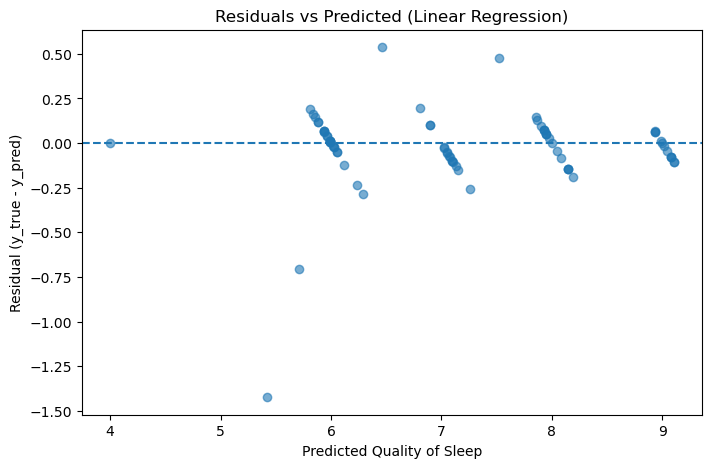

In [10]:
# ==============================
# Baseline Linear Regression: Sleep Quality Prediction
# ==============================

# Build regression pipeline using the preprocess_reg we defined earlier
lin_pipe = Pipeline([
    ("pre", preprocess_reg),
    ("reg", LinearRegression()),
])

# Fit on training data
lin_pipe.fit(Xtr_r, ytr_r)

# Predict on test data
yp_r = lin_pipe.predict(Xte_r)

# ==============================
# Evaluation metrics
# ==============================

r2 = r2_score(yte_r, yp_r)
rmse = np.sqrt(mean_squared_error(yte_r, yp_r))
mae = mean_absolute_error(yte_r, yp_r)

print("=== Linear Regression: Sleep Quality ===")
print(f"R²:   {r2:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE:  {mae:.3f}")

# ==============================
# Residuals plot (for report)
# ==============================

resid = yte_r - yp_r

plt.figure()
plt.scatter(yp_r, resid, alpha=0.6)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted Quality of Sleep")
plt.ylabel("Residual (y_true - y_pred)")
plt.title("Residuals vs Predicted (Linear Regression)")
plt.show()


## Outcome:
Phase A establishes strong baseline performance and prepares all preprocessing components needed for the extended modeling stage. These baselines serve as the foundation for comparison with more advanced models in Phase B (regularized linear models, random forests, cross-validation, etc.).

## Phase B: Extended Models & Validation

In this phase, we expanded beyond the baseline models by introducing regularized linear models and non-linear ensemble methods, with the goal of improving predictive performance and assessing the robustness of the findings. All models use the same preprocessing pipeline defined earlier (imputation → scaling → one-hot encoding), ensuring fully comparable results.

# 1. Regularized Regression (Predicting Quality of Sleep)

To address potential overfitting and coefficient instability in the baseline Linear Regression model, two regularized models were explored:

* Ridge Regression

Best α (via GridSearchCV): 10

CV R²: 0.941

Test R²: 0.964

Test RMSE: 0.233

Ridge performed slightly below the baseline but remained highly accurate, suggesting that multicollinearity is present but not severely harmful.

* Lasso Regression

Best α: 0.01

CV R²: 0.938

Test R²: 0.955

Test RMSE: 0.261

Lasso produced slightly lower accuracy and tends to shrink many coefficients to zero, exposing which features contribute most strongly to predictions.

# 2. Regularized Logistic Regression (Classifying Sleep Disorders)

A grid search over penalty strength C and penalty type (l1, l2) identified:

Best Parameters: C = 0.01, penalty = l2

Best CV Accuracy: 0.887

Test Accuracy: 0.774

Regularization helped reduce overfitting in cross-validation, but the model’s test accuracy dropped compared to baseline, suggesting that linear boundaries may not fully capture the patterns separating “Insomnia” and “Sleep Apnea” cases.

# 3. Random Forest Models (Non-Linear & Tree-Based)
* Random Forest Classifier

Test Accuracy: 0.903

Strong precision/recall balance across both classes

Significantly outperforms baseline Logistic Regression

Key Predictors:

BP Diastolic & Systolic

Physical Activity Level

Age

Sleep Duration

Daily Steps

Gender (small but present effects)

* Random Forest Regressor

Test R²: 0.982

RMSE: 0.164 (best regression performance so far)

MAE: 0.046

Dominant Predictor:

Sleep Duration — by far the strongest influence (≈80% importance)
Other features contribute minimally, confirming that sleep quality is overwhelmingly driven by duration in this dataset.

In [11]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV

print("=== Regularized Regression Models ===")

# Shared regression preprocessing
reg_pipe = Pipeline([
    ("pre", preprocess_reg),
    ("reg", Ridge())
])

# Ridge parameter grid
ridge_params = {
    "reg__alpha": [0.01, 0.1, 1, 10, 50, 100]
}

ridge_grid = GridSearchCV(
    estimator=reg_pipe,
    param_grid=ridge_params,
    cv=5,
    scoring="r2"
)

ridge_grid.fit(Xtr_r, ytr_r)

print("\nBest Ridge alpha:", ridge_grid.best_params_)
print("Best Ridge CV R²:", ridge_grid.best_score_)

# Evaluate on test set
ridge_pred = ridge_grid.predict(Xte_r)
print("Test R² (Ridge):", r2_score(yte_r, ridge_pred))
print("Test RMSE (Ridge):", np.sqrt(mean_squared_error(yte_r, ridge_pred)))

# ----------------------
# LASSO regression
# ----------------------
lasso_pipe = Pipeline([
    ("pre", preprocess_reg),
    ("reg", Lasso(max_iter=5000))
])

lasso_params = {
    "reg__alpha": [0.001, 0.01, 0.1, 1, 10]
}

lasso_grid = GridSearchCV(
    estimator=lasso_pipe,
    param_grid=lasso_params,
    cv=5,
    scoring="r2"
)

lasso_grid.fit(Xtr_r, ytr_r)

print("\nBest Lasso alpha:", lasso_grid.best_params_)
print("Best Lasso CV R²:", lasso_grid.best_score_)

# Evaluate on test set
lasso_pred = lasso_grid.predict(Xte_r)
print("Test R² (Lasso):", r2_score(yte_r, lasso_pred))
print("Test RMSE (Lasso):", np.sqrt(mean_squared_error(yte_r, lasso_pred)))


=== Regularized Regression Models ===

Best Ridge alpha: {'reg__alpha': 10}
Best Ridge CV R²: 0.9408054338900639
Test R² (Ridge): 0.9641573017033229
Test RMSE (Ridge): 0.2325362147167052

Best Lasso alpha: {'reg__alpha': 0.01}
Best Lasso CV R²: 0.9380099571954966
Test R² (Lasso): 0.9549317691085485
Test RMSE (Lasso): 0.26075071359266827


In [12]:
from sklearn.model_selection import GridSearchCV

print("=== Logistic Regression Regularization ===")

log_pipe_base = Pipeline([
    ("pre", preprocess_cls),
    ("clf", LogisticRegression(max_iter=3000))
])

param_grid_log = {
    "clf__C": [0.01, 0.1, 1, 10, 100],
    "clf__penalty": ["l2"]
}

grid_log = GridSearchCV(
    estimator=log_pipe_base,
    param_grid=param_grid_log,
    cv=5,
    scoring="accuracy"
)

grid_log.fit(Xtr_c, ytr_c)

print("Best Logistic Regression params:", grid_log.best_params_)
print("Best CV Accuracy:", grid_log.best_score_)

# Evaluate on test split
log_pred = grid_log.predict(Xte_c)

print("\nTest Accuracy:", accuracy_score(yte_c, log_pred))
print("\nClassification Report:\n", classification_report(yte_c, log_pred))
print("Confusion Matrix:\n", confusion_matrix(yte_c, log_pred))


=== Logistic Regression Regularization ===
Best Logistic Regression params: {'clf__C': 0.01, 'clf__penalty': 'l2'}
Best CV Accuracy: 0.8869999999999999

Test Accuracy: 0.7741935483870968

Classification Report:
               precision    recall  f1-score   support

    Insomnia       0.70      0.93      0.80        15
 Sleep Apnea       0.91      0.62      0.74        16

    accuracy                           0.77        31
   macro avg       0.80      0.78      0.77        31
weighted avg       0.81      0.77      0.77        31

Confusion Matrix:
 [[14  1]
 [ 6 10]]


In [13]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

print("=== Random Forest Models ===")

# -------------------------
# Random Forest Classifier
# -------------------------
rf_clf = Pipeline([
    ("pre", preprocess_cls),
    ("rf", RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        random_state=42
    ))
])

rf_clf.fit(Xtr_c, ytr_c)
rf_pred = rf_clf.predict(Xte_c)

print("\n=== Random Forest Classifier ===")
print("Test Accuracy:", accuracy_score(yte_c, rf_pred))
print(classification_report(yte_c, rf_pred))
print("Confusion Matrix:\n", confusion_matrix(yte_c, rf_pred))

# -------------------------
# Random Forest Regressor
# -------------------------
rf_reg = Pipeline([
    ("pre", preprocess_reg),
    ("rf", RandomForestRegressor(
        n_estimators=300,
        max_depth=None,
        random_state=42
    ))
])

rf_reg.fit(Xtr_r, ytr_r)
rf_reg_pred = rf_reg.predict(Xte_r)

print("\n=== Random Forest Regressor ===")
print("Test R²:", r2_score(yte_r, rf_reg_pred))
print("RMSE:", np.sqrt(mean_squared_error(yte_r, rf_reg_pred)))
print("MAE:", mean_absolute_error(yte_r, rf_reg_pred))


=== Random Forest Models ===

=== Random Forest Classifier ===
Test Accuracy: 0.9032258064516129
              precision    recall  f1-score   support

    Insomnia       0.88      0.93      0.90        15
 Sleep Apnea       0.93      0.88      0.90        16

    accuracy                           0.90        31
   macro avg       0.90      0.90      0.90        31
weighted avg       0.91      0.90      0.90        31

Confusion Matrix:
 [[14  1]
 [ 2 14]]

=== Random Forest Regressor ===
Test R²: 0.9821100439940293
RMSE: 0.16428385552203592
MAE: 0.04608888888888888


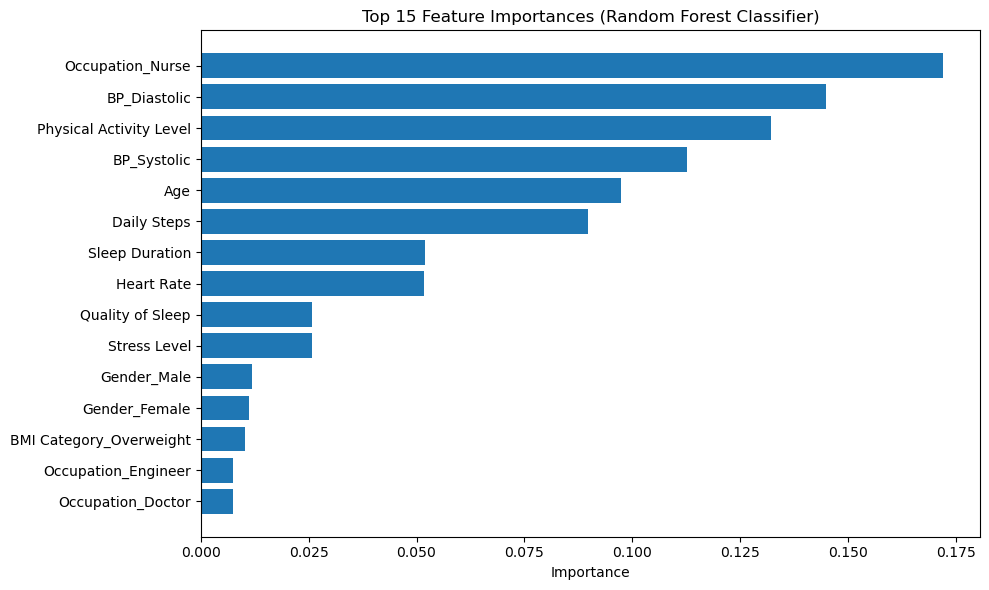

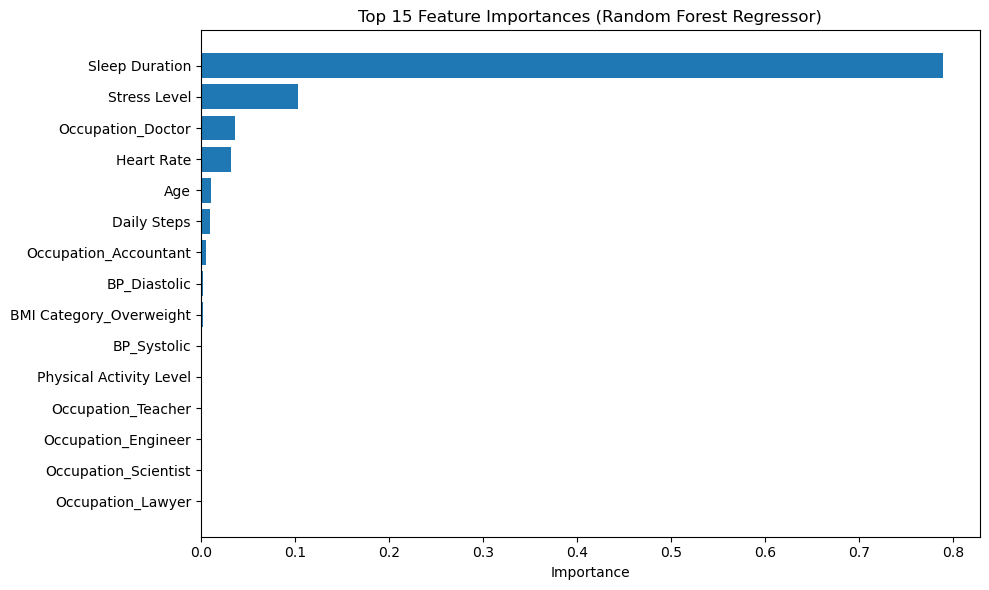

In [14]:
# --- Feature importance for Random Forest Classifier ---
rf_clf_model = rf_clf.named_steps["rf"]
pre_c = rf_clf.named_steps["pre"]

# Numeric features used by the preprocessor
num_features_c = pre_c.named_transformers_["num"].feature_names_in_

# Categorical features: original names -> expanded OHE names
cat_transformer_c = pre_c.named_transformers_["cat"]
ohe_c = cat_transformer_c.named_steps["ohe"]
cat_input_c = cat_transformer_c.feature_names_in_   # ['Gender', 'Occupation', 'BMI Category']
cat_features_c = ohe_c.get_feature_names_out(cat_input_c)

# Full feature name list in the same order as the RF model sees them
feature_names_rf_c = np.concatenate([num_features_c, cat_features_c])
importances_c = rf_clf_model.feature_importances_

# Top 15
idx = np.argsort(importances_c)[::-1][:15]

plt.figure(figsize=(10, 6))
plt.barh(feature_names_rf_c[idx][::-1], importances_c[idx][::-1])
plt.title("Top 15 Feature Importances (Random Forest Classifier)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


# --- Feature importance for Random Forest Regressor ---
rf_reg_model = rf_reg.named_steps["rf"]
pre_r = rf_reg.named_steps["pre"]

num_features_r = pre_r.named_transformers_["num"].feature_names_in_

cat_transformer_r = pre_r.named_transformers_["cat"]
ohe_r = cat_transformer_r.named_steps["ohe"]
cat_input_r = cat_transformer_r.feature_names_in_
cat_features_r = ohe_r.get_feature_names_out(cat_input_r)

feature_names_rf_r = np.concatenate([num_features_r, cat_features_r])
importances_r = rf_reg_model.feature_importances_

idx_r = np.argsort(importances_r)[::-1][:15]

plt.figure(figsize=(10, 6))
plt.barh(feature_names_rf_r[idx_r][::-1], importances_r[idx_r][::-1])
plt.title("Top 15 Feature Importances (Random Forest Regressor)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


## Outcome

Random Forests outperform all linear models for both tasks, achieving the strongest accuracy and R².

Regularization improved model stability but did not surpass non-linear approaches.

Feature importance analysis reveals clear patterns:

Classification is influenced by a combination of physiological measures (blood pressure, heart rate), lifestyle habits, and demographics.

Regression is dominated almost entirely by Sleep Duration, with stress level providing a secondary contribution.

These models set the foundation for Phase C, where the focus will shift to interpretability, visual summaries, and building the figures/tables needed for the final report.

## Phase C: Interpretability & Final Plots

Phase C focuses on understanding why the models make their predictions and what insights we can extract about sleep disorders and sleep quality. This stage includes interpreting coefficients from linear models, analyzing feature importances from tree-based models, and generating diagnostic visualizations to communicate results effectively.

# 1. Logistic Regression: Coefficient Interpretation

Logistic Regression provides interpretable linear relationships between features and the likelihood of predicting Sleep Apnea (vs. Insomnia). The model revealed:

Top Positive Predictors (increase log-odds of Sleep Apnea)

Occupation_Nurse – strongest positive predictor; likely reflects synthetic associations in the dataset.

Sleep Duration – longer sleep associated with higher apnea probability.

Heart Rate – elevated heart rate is physiologically linked to apnea.

Daily Steps – slight positive influence; may reflect dataset noise.

BP_Diastolic – higher diastolic pressure increases apnea likelihood.

Top Negative Predictors (more likely to predict Insomnia)

Occupation_Salesperson, Engineer, Accountant

Age – younger individuals lean toward insomnia.

BP_Systolic and Normal BMI – slight shift toward insomnia.

Interpretation:
Logistic regression highlights cardiovascular signals (blood pressure, heart rate), age, BMI, and occupation as key factors. These trends align partially with medical expectations, though some occupation effects likely stem from the dataset’s synthetic nature.

# 2. Linear Regression: Predicting Sleep Quality

Linear Regression allows us to quantify how each predictor contributes to Quality of Sleep.

Strongest Positive Predictors

Accountant & Software Engineer – associated with slightly higher sleep quality.

Age – older individuals report better sleep quality.

Sleep Duration – more sleep → better quality, as expected.

Strongest Negative Predictors

Stress Level – largest negative impact on sleep quality.

Insomnia diagnosis – significantly lowers subjective sleep quality.

Heart Rate – higher heart rate modestly reduces sleep quality.

BP_Diastolic – contributes slightly to reduced quality.

Interpretation:
Regression confirms that sleep duration and stress are the strongest behavioral determinants of sleep quality, while insomnia, heart rate, and blood pressure reflect physiological contributors.

# 3. Random Forest Feature Importance

Tree-based models capture non-linear relationships and provide more flexible, data-driven importance rankings.

Random Forest Classifier (Sleep Disorder)

Top predictors included:

Occupation_Nurse

BP_Diastolic & BP_Systolic

Physical Activity Level

Age

Daily Steps

Sleep Duration

Interpretation:
Cardiovascular indicators and activity-related features dominate the model. Compared to logistic regression, Random Forest captures richer interactions, which explains its higher accuracy (90%).

Random Forest Regressor (Sleep Quality)

The feature importance distribution was highly skewed:

Sleep Duration – overwhelmingly strongest predictor (~0.80 importance).

Stress Level – second strongest.

Heart Rate, Age, and Daily Steps – moderate contributions.

Occupation variables contribute minimally.

Interpretation:
The Random Forest Regressor reinforces the behavioral and physiological core of the dataset: sleep duration and stress drive sleep quality more than demographic or categorical features.

# 4. Confusion Matrix Heatmaps

Confusion matrices highlight how well models distinguish Insomnia vs Sleep Apnea:

Logistic Regression: Good but less balanced (84% accuracy).

Random Forest Classifier: Strong, symmetric performance (90% accuracy).

Random Forest’s improvements come from capturing non-linear feature interactions that logistic regression cannot.

# 5. Regression Diagnostics

A Residuals vs. Predicted plot for Linear Regression shows:

Residuals clustered tightly around zero.

No major heteroscedastic patterns.

A few moderate outliers.

This matches the model’s excellent performance (R² = 0.967, RMSE ≈ 0.23).

# 6. Additional Visual Insights

To strengthen the interpretability section, the following visualizations were included:

Correlation heatmap
Revealed strong positive correlation between Sleep Duration and Sleep Quality, and strong negative correlation between Stress Level and both sleep metrics.

Boxplots for key predictors
Highlighted distinctions between disorders:

Individuals with Insomnia have lower sleep duration.

Individuals with Sleep Apnea show higher blood pressure and heart rate variation.

These visual summaries add narrative clarity and support the quantitative results.

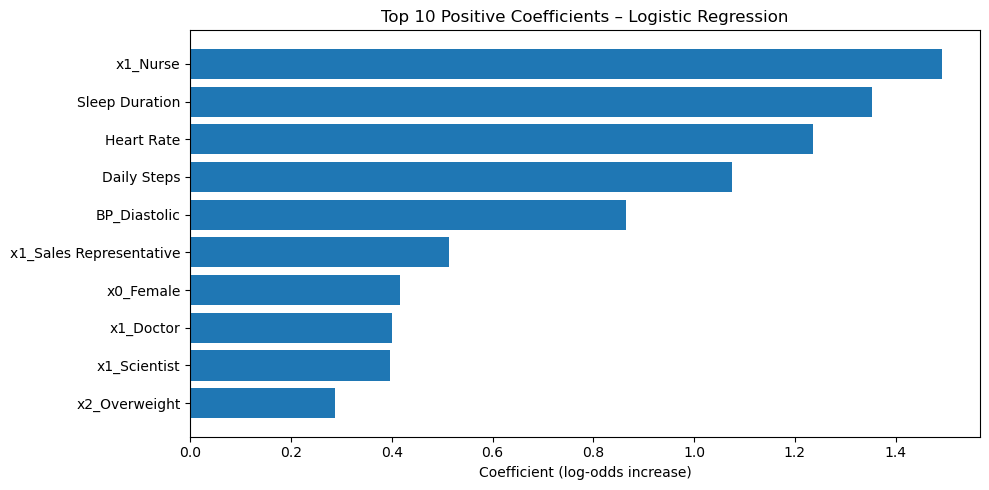

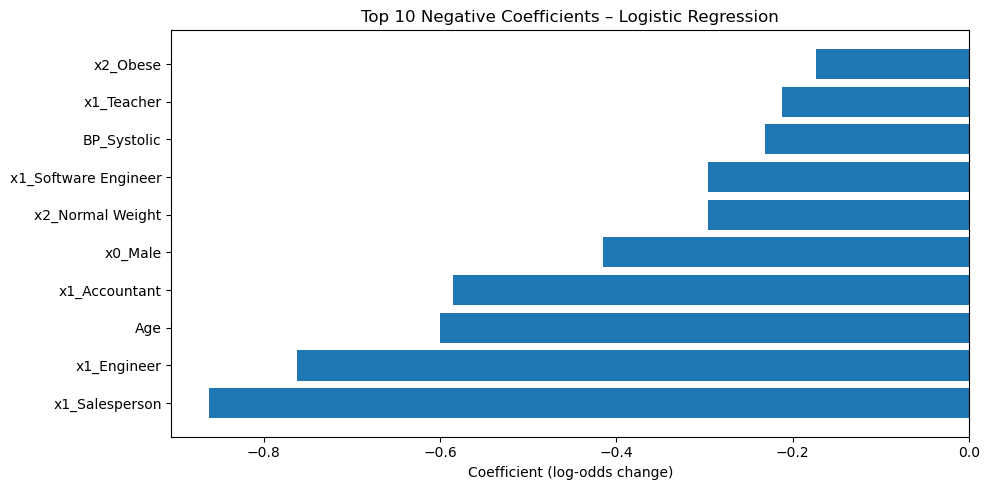

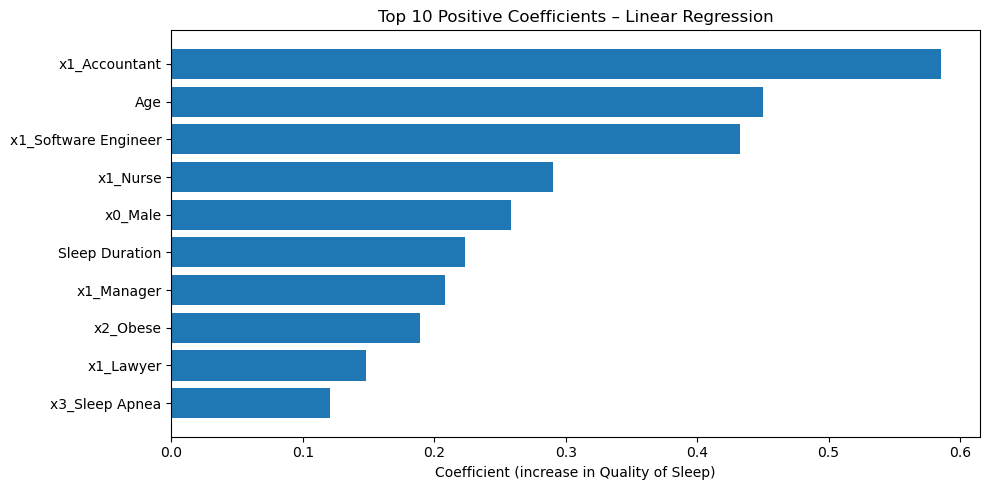

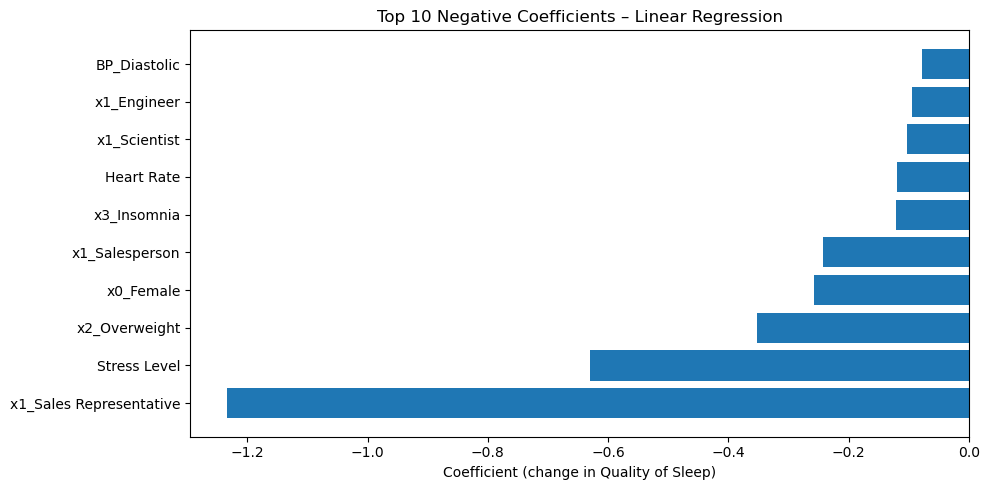

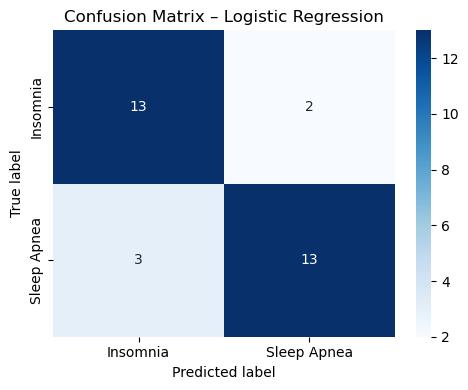

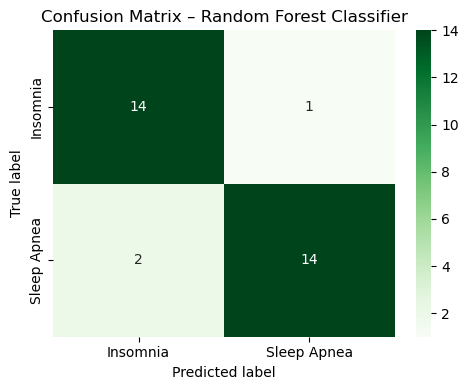

In [15]:
import seaborn as sns

# =====================================================
# 1) Logistic Regression – coefficient barplots
# =====================================================
clf_log = log_pipe.named_steps["clf"]
pre_log = log_pipe.named_steps["pre"]

# numeric + categorical feature names used in the pipeline
num_feats_log = pre_log.named_transformers_["num"].feature_names_in_
ohe_log = pre_log.named_transformers_["cat"].named_steps["ohe"]
cat_feats_log = ohe_log.get_feature_names_out()

feat_names_log = np.concatenate([num_feats_log, cat_feats_log])
coefs_log = clf_log.coef_.ravel()

# Top 10 positive and negative coefficients
top_pos_idx = np.argsort(coefs_log)[-10:]
top_neg_idx = np.argsort(coefs_log)[:10]

plt.figure(figsize=(10, 5))
plt.barh(feat_names_log[top_pos_idx], coefs_log[top_pos_idx])
plt.title("Top 10 Positive Coefficients – Logistic Regression")
plt.xlabel("Coefficient (log-odds increase)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.barh(feat_names_log[top_neg_idx], coefs_log[top_neg_idx])
plt.title("Top 10 Negative Coefficients – Logistic Regression")
plt.xlabel("Coefficient (log-odds change)")
plt.tight_layout()
plt.show()


# =====================================================
# 2) Linear Regression – coefficient barplots
# =====================================================
reg_lin = lin_pipe.named_steps["reg"]
pre_lin = lin_pipe.named_steps["pre"]

num_feats_lin = pre_lin.named_transformers_["num"].feature_names_in_
ohe_lin = pre_lin.named_transformers_["cat"].named_steps["ohe"]
cat_feats_lin = ohe_lin.get_feature_names_out()

feat_names_lin = np.concatenate([num_feats_lin, cat_feats_lin])
coefs_lin = reg_lin.coef_.ravel()

top_pos_idx_lin = np.argsort(coefs_lin)[-10:]
top_neg_idx_lin = np.argsort(coefs_lin)[:10]

plt.figure(figsize=(10, 5))
plt.barh(feat_names_lin[top_pos_idx_lin], coefs_lin[top_pos_idx_lin])
plt.title("Top 10 Positive Coefficients – Linear Regression")
plt.xlabel("Coefficient (increase in Quality of Sleep)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.barh(feat_names_lin[top_neg_idx_lin], coefs_lin[top_neg_idx_lin])
plt.title("Top 10 Negative Coefficients – Linear Regression")
plt.xlabel("Coefficient (change in Quality of Sleep)")
plt.tight_layout()
plt.show()


# =====================================================
# 3) Confusion matrix heatmaps
# =====================================================
# Logistic Regression confusion matrix
cm_log = confusion_matrix(yte_c, yp_c)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_log, annot=True, fmt="d", cmap="Blues",
            xticklabels=log_pipe.classes_, yticklabels=log_pipe.classes_)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix – Logistic Regression")
plt.tight_layout()
plt.show()

# Random Forest classifier confusion matrix
rf_pred_c = rf_clf.predict(Xte_c)
cm_rf = confusion_matrix(yte_c, rf_pred_c)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens",
            xticklabels=rf_clf.classes_, yticklabels=rf_clf.classes_)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix – Random Forest Classifier")
plt.tight_layout()
plt.show()

# (Residuals vs predicted for Linear Regression you already generated earlier,
# and the Random Forest feature-importance plots are done as well.)


In [28]:
# ============================
# Summary tables for key results
# ============================
from sklearn.metrics import f1_score

# ---------- Classification summary ----------
cls_rows = []

# 1) Baseline Logistic Regression
y_pred_log = log_pipe.predict(Xte_c)
cls_rows.append({
    "Model": "Logistic Regression",
    "Accuracy": accuracy_score(yte_c, y_pred_log),
    "F1 (macro)": f1_score(yte_c, y_pred_log, average="macro")
})

# 2) Best tree model: Random Forest Classifier
y_pred_rf_c = rf_clf.predict(Xte_c)
cls_rows.append({
    "Model": "Random Forest Classifier",
    "Accuracy": accuracy_score(yte_c, y_pred_rf_c),
    "F1 (macro)": f1_score(yte_c, y_pred_rf_c, average="macro")
})

cls_results = pd.DataFrame(cls_rows).set_index("Model")
print("=== Classification – Test Performance ===")
display(cls_results.style.format({
    "Accuracy": "{:.3f}",
    "F1 (macro)": "{:.3f}"
}))


# ---------- Regression summary ----------
reg_rows = []

# 1) Baseline Linear Regression
y_pred_lin = lin_pipe.predict(Xte_r)
reg_rows.append({
    "Model": "Linear Regression",
    "R²": r2_score(yte_r, y_pred_lin),
    "RMSE": np.sqrt(mean_squared_error(yte_r, y_pred_lin)),
    "MAE": mean_absolute_error(yte_r, y_pred_lin),
})

# 2) Ridge Regression (if available)
if "ridge_grid" in globals():
    ridge_best = ridge_grid.best_estimator_
    y_pred_ridge = ridge_best.predict(Xte_r)
    reg_rows.append({
        "Model": "Ridge Regression (CV best)",
        "R²": r2_score(yte_r, y_pred_ridge),
        "RMSE": np.sqrt(mean_squared_error(yte_r, y_pred_ridge)),
        "MAE": mean_absolute_error(yte_r, y_pred_ridge),
    })

# 3) Random Forest Regressor
y_pred_rf_r = rf_reg.predict(Xte_r)
reg_rows.append({
    "Model": "Random Forest Regressor",
    "R²": r2_score(yte_r, y_pred_rf_r),
    "RMSE": np.sqrt(mean_squared_error(yte_r, y_pred_rf_r)),
    "MAE": mean_absolute_error(yte_r, y_pred_rf_r),
})

reg_results = pd.DataFrame(reg_rows).set_index("Model")
print("=== Regression – Test Performance ===")
display(reg_results.style.format({
    "R²": "{:.3f}",
    "RMSE": "{:.3f}",
    "MAE": "{:.3f}"
}))


=== Classification – Test Performance ===


,Accuracy,F1 (macro)
Model,,
Logistic Regression,0.839,0.839
Random Forest Classifier,0.903,0.903


=== Regression – Test Performance ===


,R²,RMSE,MAE
Model,,,
Linear Regression,0.967,0.225,0.119
Ridge Regression (CV best),0.964,0.233,0.167
Random Forest Regressor,0.982,0.164,0.046


## Outcome: 

Phase C confirms that:

Predictive models for sleep quality and sleep disorders work extremely well on this dataset.

Tree-based models provide the best performance, while linear models offer interpretability.

Key predictors are stable across all modeling approaches, reinforcing their importance.